# Predicción del precio de la vivienda en Seattle

# Entendimiento del problema


La tarea de hoy consiste en predecir el precio de viviendas ubicadas en Seattle (estado de Washington en EE.UU.). Los precios de cada casa variarán en función de sus características. 

Supondremos que estamos trabajando para una inmobiliaria y queremos hacer un sondeo de mercado. Trabajaríamos con un grupo de analistas expertos en el dominio. Para entrar en calor indagaremos un poco en el contexto de la vivienda y pensaremos en aquello que nos pueden ayudar a familiarizarnos con el problema. Aquí van una serie de suposiciones que podemos plantear.

**Hipótesis:**
- Cuantos más metros cuadrados, más habitaciones y más baños, más valdrá la casa.
- El tamaño de las casas es proporcional al número de habitaciones y de baños.
- Las casas en zonas con menor oferta serán más caras.

**Preguntas:**
- ¿Cómo afectará que la proporción de metros construidos sobre la propiedad sea mayor?, ¿aumentará su valor?
- ¿Cuál es la zona más cara por metro cuadrado?
- ¿Las casas de Queen Anne tienen un precio significativamente distinto al resto?
- ¿Existen casas con un precio demasiado bajo respecto a las características que ofrece?
- ¿Qué característica es la más importante a la hora de predecir el precio?

Para esta ocasión el proyecto no involucrará nada relacionado con el procesamiento de datos en tiempo real. Las predicciones y modelos planteados se utilizarán para realizar un posterior informe de los resultados. Esta documentación podría servirnos para comunicar los resultados al cliente final.

# Cargamos los conjuntos de datos
En esta ocasión el conjunto de datos se compone de dos ficheros de datos csv: uno de entrenamiento y otro de test.

El de entrenamiento será usado para todas las pruebas y entrenamientos de modelos que queramos hacer. 

El de test es totalmente invisible a los procedimientos que desarrollemos a lo largo del proyecto. Se usará finalmente cuando tengamos que medir el rendimiento de algún predictor.

Los conjuntos de datos no son extremadamente grandes y los podemos almacenar en memorio. Optamos por trabajar de forma sencilla con Pandas.

In [205]:
import kagglehub
import os
import pandas as pd

############ SI TRABAJAMOS FUERA DE UN ENTORNO DE KAGGLE ##################
# Ruta de descarga predeterminada de kagglehub
path = os.path.expanduser("~/.cache/kagglehub/datasets/samuelcortinhas/house-price-prediction-seattle")

# Verificamos si ya existe
if not os.path.exists(path):
    print("⏬ Descargando dataset...")
    kagglehub.dataset_download("samuelcortinhas/house-price-prediction-seattle")
else:
    print("✅ Dataset ya descargado.")

# Buscamos CSV dentro de la carpeta (puede estar directamente o dentro de una subcarpeta)
def find_csv_files(base_folder):
    for root, dirs, files in os.walk(base_folder):
        if 'train.csv' in files and 'test.csv' in files:
            return root  # Ruta donde están los CSV
    return None

# Encontramos el directorio donde se encuentran nuestros CSV
csv_folder = find_csv_files(path)
if csv_folder is None:
    raise FileNotFoundError("No se encontraron 'train.csv' y 'test.csv' dentro del dataset descargado.")

print("CSV files found in:", csv_folder)

# Ruta a los datasets
train_data_path = os.path.join(csv_folder, 'train.csv')
test_data_path = os.path.join(csv_folder, 'test.csv')


############ SI TRABAJAMOS EN UN ENTORNO DE KAGGLE #######################
# path = '/kaggle/input/house-price-prediction-seattle/'

# Obtenemos las rutas donde se encuentran ambos conjuntos
# train_data_path = os.path.join(path, 'train.csv')
# test_data_path = os.path.join(path, 'test.csv')
# print(train_data_path)

###############################################################################

# Cargamos los conjuntos de datos
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

✅ Dataset ya descargado.
CSV files found in: C:\Users\Víctor/.cache/kagglehub/datasets/samuelcortinhas/house-price-prediction-seattle\versions\1


In [206]:
# Las dimensiones del training set
print(train_data.shape)

# Las dimensiones del test set
print(test_data.shape)

(2016, 8)
(505, 8)


En los 2 conjuntos tenemos 8 columnas. Sin embargo, el training set tiene más filas (2016) que el test set (505).

In [207]:
# Mostramos el nombre de las variables
print(train_data.columns)

Index(['beds', 'baths', 'size', 'size_units', 'lot_size', 'lot_size_units',
       'zip_code', 'price'],
      dtype='object')


Parece ser que las columnas representan las características de la casa.
Estas son las variables/columnas con las que contamos:

| **Columna**      | **Descripción**                                                                                              |
| ---------------- | ---------------------------------------------------------------------------------------------------------------------- |
| `beds`           | Número de dormitorios en la propiedad                                                                                  |
| `baths`          | Número de baños en la propiedad. Nota: 0.5 corresponde a un medio baño (con lavabo e inodoro, pero sin bañera o ducha) |
| `size`           | Superficie total construida de la propiedad                                                                            |
| `size_units`     | Unidades de la medida anterior                                                                                         |
| `lot_size`       | Superficie total del terreno donde se encuentra la propiedad. El terreno pertenece al dueño de la casa                 |
| `lot_size_units` | Unidades de la medida anterior                                                                                         |
| `zip_code`       | Código postal. Es un código de uso postal en Estados Unidos                                                            |
| `price`          | Precio por el que se vendió la propiedad (en dólares estadounidenses)                                                  |


In [208]:
train_data.head()

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
0,3,2.5,2590.0,sqft,6000.00,sqft,98144,795000.0
1,4,2.0,2240.0,sqft,0.31,acre,98106,915000.0
2,4,3.0,2040.0,sqft,3783.00,sqft,98107,950000.0
3,4,3.0,3800.0,sqft,5175.00,sqft,98199,1950000.0
4,2,2.0,1042.0,sqft,NaN,NaN,98102,950000.0


En el DataFrame no hay ningún índice por el que se puedan agrupar filas para formar una instancia completa. Por ende, deducimos que cada fila representará una instancia de una vivienda.

A partir de las descripciones de las columnas vamos a tratar de clasificicarlas por su tipo:

- **Numéricas**
  - Discretas: `beds`, `baths`
  - Continuas: `size`, `lot_size`, `price`
- **Categóricas (nominales):** `size_units`, `lot_size_units`, `zip_code`
- **Booleanas:** No hay.
- **Fechas/Temporales:** No hay.

A continuación mostramos estadísticos de las variables numéricas.

In [209]:
num_train_data = train_data.loc[:, ["beds", "baths", "size", "lot_size", "price"]]
num_train_data.describe()

,beds,baths,size,lot_size,price
count,2016.000000,2016.000000,2016.000000,1669.000000,2.016000e+03
mean,2.857639,2.159970,1735.740575,3871.059694,9.636252e+05
std,1.255092,1.002023,920.132591,2719.402066,9.440954e+05
min,1.000000,0.500000,250.000000,0.230000,1.590000e+05
25%,2.000000,1.500000,1068.750000,1252.000000,6.017500e+05
50%,3.000000,2.000000,1560.000000,4000.000000,8.000000e+05
75%,4.000000,2.500000,2222.500000,6000.000000,1.105250e+06
max,15.000000,9.000000,11010.000000,9998.000000,2.500000e+07


Las escalas de `beds` y `baths` son muy distintas a las de `size` y `lot_size`. Si nos fijamos en desviación típico (`std`), podemos observar que las varianzas son muy distintas. Por otro lado, `price` podría tener un problema de crecimiento exponencial de los datos.
Ahora, imprimamos información del tipo de las columnas.


In [210]:
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            2016 non-null   int64  
 1   baths           2016 non-null   float64
 2   size            2016 non-null   float64
 3   size_units      2016 non-null   object 
 4   lot_size        1669 non-null   float64
 5   lot_size_units  1669 non-null   object 
 6   zip_code        2016 non-null   int64  
 7   price           2016 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 126.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            505 non-null    int64  
 1   baths           505 non-null    float64
 2   size            505 non-null    float64
 3   size_units      505 non-null    object 
 

No parece muy adecuado representar los códigos zip como un entero cuando el valor que representa es una categoría.

Parece que tenemos valores nulos en las columnas `lot_size` y `lot_size_units`. Estas columnas hacen referencia al tamaño del inmueble y tendremos que aplicar una serie de transformaciones sobre ellas. 

1. En primer lugar, el área del inmueble se representa con distintas unidades de medida. Habrá que aplicar algún tipo de transformación para establecer una única unidad de medida para todas las casas.
2. En segundo lugar, menos del 20 % de los registros de esas columnas están vacías. Se tomará una decisión respecto a los valores faltantes.

Anteriormente pudimos comprobar con `describe()` que no existen valores imposibles en los extremos (no hay valores negativos en ninguna columna, por ejemplo). Otra forma de comprobar que todos los registros tienen sentido es asegurándonos que ninguna casa tiene más área construida que área total.

¡Pero OJO! Las variables `size` y `lot_size` podrían emplear distintas unidades de medidas, por lo que será otro punto a tratar en el preprocesamiento.

In [211]:
impossible_inds = train_data.size > train_data.lot_size
impossible_inds

0        True
1        True
2        True
3        True
4       False
        ...  
2011     True
2012    False
2013     True
2014    False
2015     True
Name: lot_size, Length: 2016, dtype: bool

# Preprocesamiento y análisis exploratorio de datos

En primer lugar, separemos los predictores de la variable objetivo.

In [212]:
# Separamos la variable objetivo y las características
y_train = train_data.price
X_train = train_data.drop("price", axis=1)

y_test = test_data.price
X_test = test_data.drop("price", axis=1)

Veamos los valores únicos que almacena `lot_size` y `lot_size_units`.

In [213]:
print(f"Los valores únicos de size_units: {train_data.size_units.unique()}")
print(f"Los valores únicos de lot_size_units: {train_data.lot_size_units.unique()}")

Los valores únicos de size_units: ['sqft']
Los valores únicos de lot_size_units: ['sqft' 'acre' nan]


Recordemos que:
- 1 acre = 43560 sqft

Vamos a crear un transformador que haga la conversión de acre a sqft.

In [214]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

class UnifiedUnitTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Evitamos modificar el dataframe original
        X = X.copy()
        
        # Hacemos la conversión de acres a sqft
        X.loc[X['size_units'] == "acre", "size"] *= 43560.0
        X.loc[X['lot_size_units'] == "acre", "lot_size"] *= 43560.0

        # Eliminamos las columnas que indica las unidades
        X = X.drop("size_units", axis=1)
        X = X.drop("lot_size_units", axis=1)

        return X

# Creamos un transformador de unidades
units_transformer = UnifiedUnitTransformer()

# Lo entrenamos y transformamos los datos
X_train_prep = units_transformer.fit_transform(X_train)
X_train_prep.head()


,beds,baths,size,lot_size,zip_code
0,3,2.5,2590.0,6000.0,98144
1,4,2.0,2240.0,13503.6,98106
2,4,3.0,2040.0,3783.0,98107
3,4,3.0,3800.0,5175.0,98199
4,2,2.0,1042.0,NaN,98102


In [215]:
X_test_prep = units_transformer.transform(test_data)
X_test_prep.head()

,beds,baths,size,lot_size,zip_code,price
0,3,3.0,2850.0,4200.0,98119,1175000.0
1,4,5.0,3040.0,5002.0,98106,1057500.0
2,3,1.0,1290.0,6048.0,98125,799000.0
3,3,2.0,2360.0,12196.8,98188,565000.0
4,3,3.5,1942.0,1603.0,98107,1187000.0


Ahora toca pensar que vamos a hacer con los valores nulos de `lot_size`. 

Se nos puede venir a la mente imputar esos valores con alguna estrategia (aplicar una media o mediana). El problema que puede conllevar es que si el valor medio o mediano de `lot_size` es inferior al valor de `size` no estaríamos imputando valores realistas. 

Una opción un poco más sofisticada sería elaborar un modelo de regresión lineal con los datos de `size` para predecir `lot_size`. Lo podríamos entrenar con los datos existentes y predecir los no conocidos.

Como queremos hacer un preprocesado sencillo, simplemente eliminaremos esas instancias que tengan valores faltantes.

In [216]:
X_train_prep.dropna(axis=0, inplace=True)
X_test_prep.dropna(axis=0, inplace=True)

Ya podemos comprobar que **ninguna casa tiene más área construida que área total**.

In [217]:
X_train_prep.head()

,beds,baths,size,lot_size,zip_code
0,3,2.5,2590.0,6000.0,98144
1,4,2.0,2240.0,13503.6,98106
2,4,3.0,2040.0,3783.0,98107
3,4,3.0,3800.0,5175.0,98199
5,2,2.0,1190.0,43560.0,98107


In [218]:
impossibles = X_train_prep['size'] > X_train_prep['lot_size']
impossible_instances = X_train_prep.loc[impossibles]

impossible_inds = impossible_instances.index
impossible_instances.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261 entries, 8 to 2009
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   beds      261 non-null    int64  
 1   baths     261 non-null    float64
 2   size      261 non-null    float64
 3   lot_size  261 non-null    float64
 4   zip_code  261 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 12.2 KB


¡Vaya! Parece que hay 261 instancias que no tienen valores coherentes para el tamaño del terreno de su propiedad. Puede que sean demasiadas instancias con errores. Lo ideal sería preguntarle al creador del dataset. Mientras tanto, vamos a eliminarlas.

In [219]:
X_train_prep.drop(impossible_inds, axis=0, inplace=True)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1408 entries, 0 to 2015
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   beds      1408 non-null   int64  
 1   baths     1408 non-null   float64
 2   size      1408 non-null   float64
 3   lot_size  1408 non-null   float64
 4   zip_code  1408 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 66.0 KB


In [220]:
# Que no se nos olvide eliminar de y los valores de instancias borradas
y_train_prep = y_train[X_train_prep.index]
y_test_prep = y_test[X_test_prep.index]

Ahora vamos a tratar de averiguar si existe una relación entre el número de habitaciones y baños con el tamaño de la vivienda.

In [221]:
import seaborn as sns
import matplotlib.pyplot as plt


beds_and_baths = X_train_prep.loc[:, ['beds', 'baths']].copy()

# Copiamos dos columnas bed y baths de tipo string
beds_and_baths['beds_str'] = beds_and_baths['beds'].astype(str)
beds_and_baths['baths_str'] = beds_and_baths['baths'].astype(str)

beds_and_baths['size'] = X_train_prep['size']

# Ordenamos los índices para beds y baths
beds_order = sorted(beds_and_baths['beds_str'].unique(), key=float)
baths_order = sorted(beds_and_baths['baths_str'].unique(), key=float)


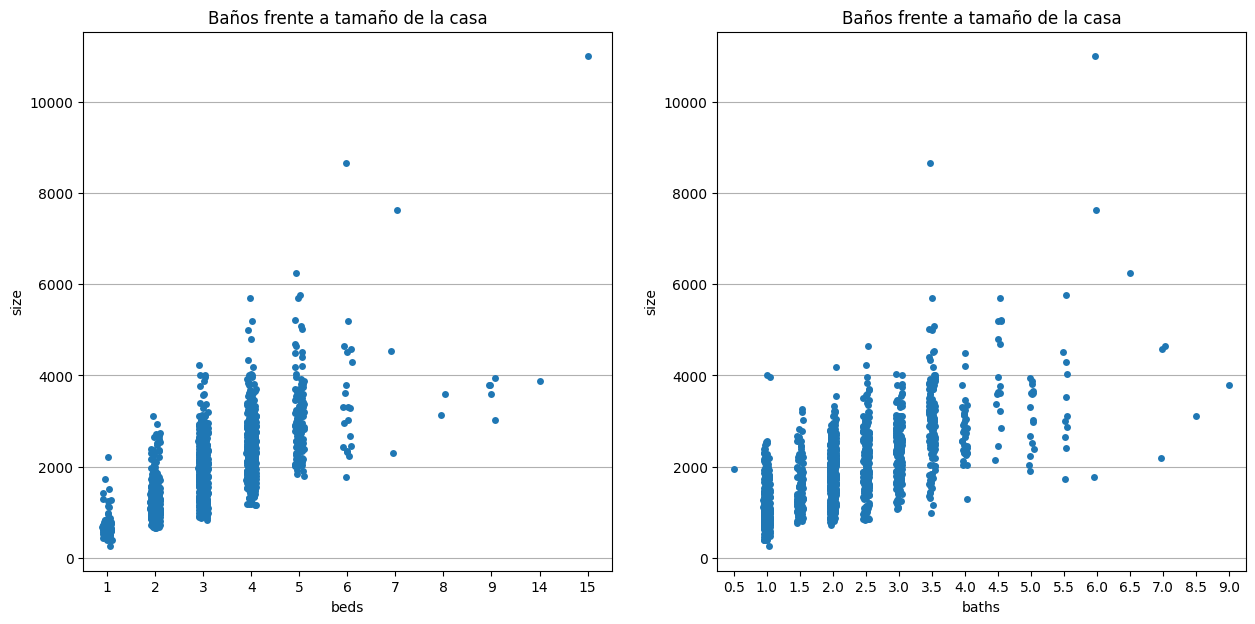

In [222]:

plt.figure(figsize=(15, 7))

# Primera gráfica: Camas frente a tamaño de la casa
plt.subplot(1, 2, 1)
plt.title("Baños frente a tamaño de la casa")
sns.stripplot(data=beds_and_baths, x = "beds", y = "size", order = beds_order, jitter=True)
plt.grid(axis='y')

# Segunda gráfica: Baños frente a tamaño de la casa
plt.subplot(1, 2, 2)
plt.title("Baños frente a tamaño de la casa")
sns.stripplot(data=beds_and_baths, x = "baths", y = "size", order = baths_order, jitter=True)
plt.grid(axis='y')


De forma visual podemos comprobar que lo más común es que el tamaño de la casa influye en el número de habitaciones y cuartos de baño. Según aumenta el número de habitaciones aumenta el espacio de la casa, pero a partir de 6 habitaciones el aumento del espacio habitable se desvanece. Ocurre lo mismo con casas a partir de 5 baños. De todos modos, tengamos en cuenta que lo normal no suele ser que una casa tenga más de 6 habitaciones y 5 baños.

**¿Son las zonas con menos ofertas de casas más caras?**

- Primero hay que contar el número de casas que hay por zona (`zip_code`)
- Con una función map (`apply` para series de Pandas) crear una columna `houses_per_zone`.
- Realizamos un scatter plot: Eje x -> `houses_per_zone`. Eje y -> `price`

<Axes: xlabel='houses_per_zone', ylabel='price'>

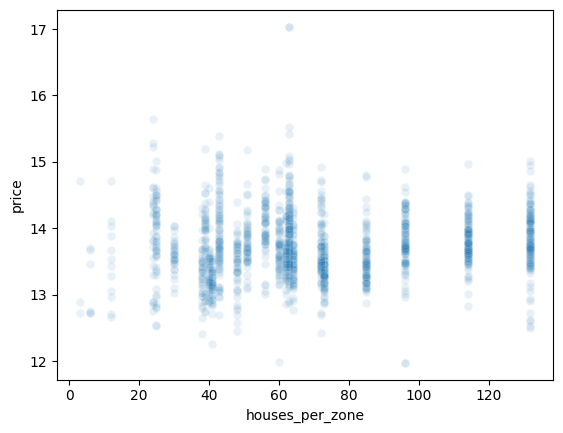

In [223]:
import numpy as np
# Contamos las casas por zona
houses_per_zone = X_train_prep["zip_code"].value_counts()

# Creamos una columna para indicar el número de casas en la misma zona
houses_per_zone = X_train_prep["zip_code"].apply(lambda x: houses_per_zone[x])

# Debido al crecimiento exponencial de price tomaremos el logaritmo de sus valores
y_train_prep = y_train_prep.apply(lambda x: np.log(x))
y_test_prep = y_test_prep.apply(lambda x: np.log(x))

# Creamos un DataFrame con los datos que vamos a usar para el gráfico
demand_data = pd.DataFrame((houses_per_zone, y_train_prep)).T

# Le cambiamos el nombre a la serie con el conteo de casas por zona
demand_data.rename(columns={'zip_code': "houses_per_zone"}, inplace=True)

# Creamos un diagrama de dispersión que enfrente el número de casas en la zona con el precio
sns.scatterplot(
    data = demand_data,
    x = "houses_per_zone", y = "price",
    alpha=0.1
)

No se observa ninguna relación entre demanda y precio.

**¿Cuáles son las zonas más caras de Seattle?**

Text(0.5, 1.0, 'Valor mediano de la zona')

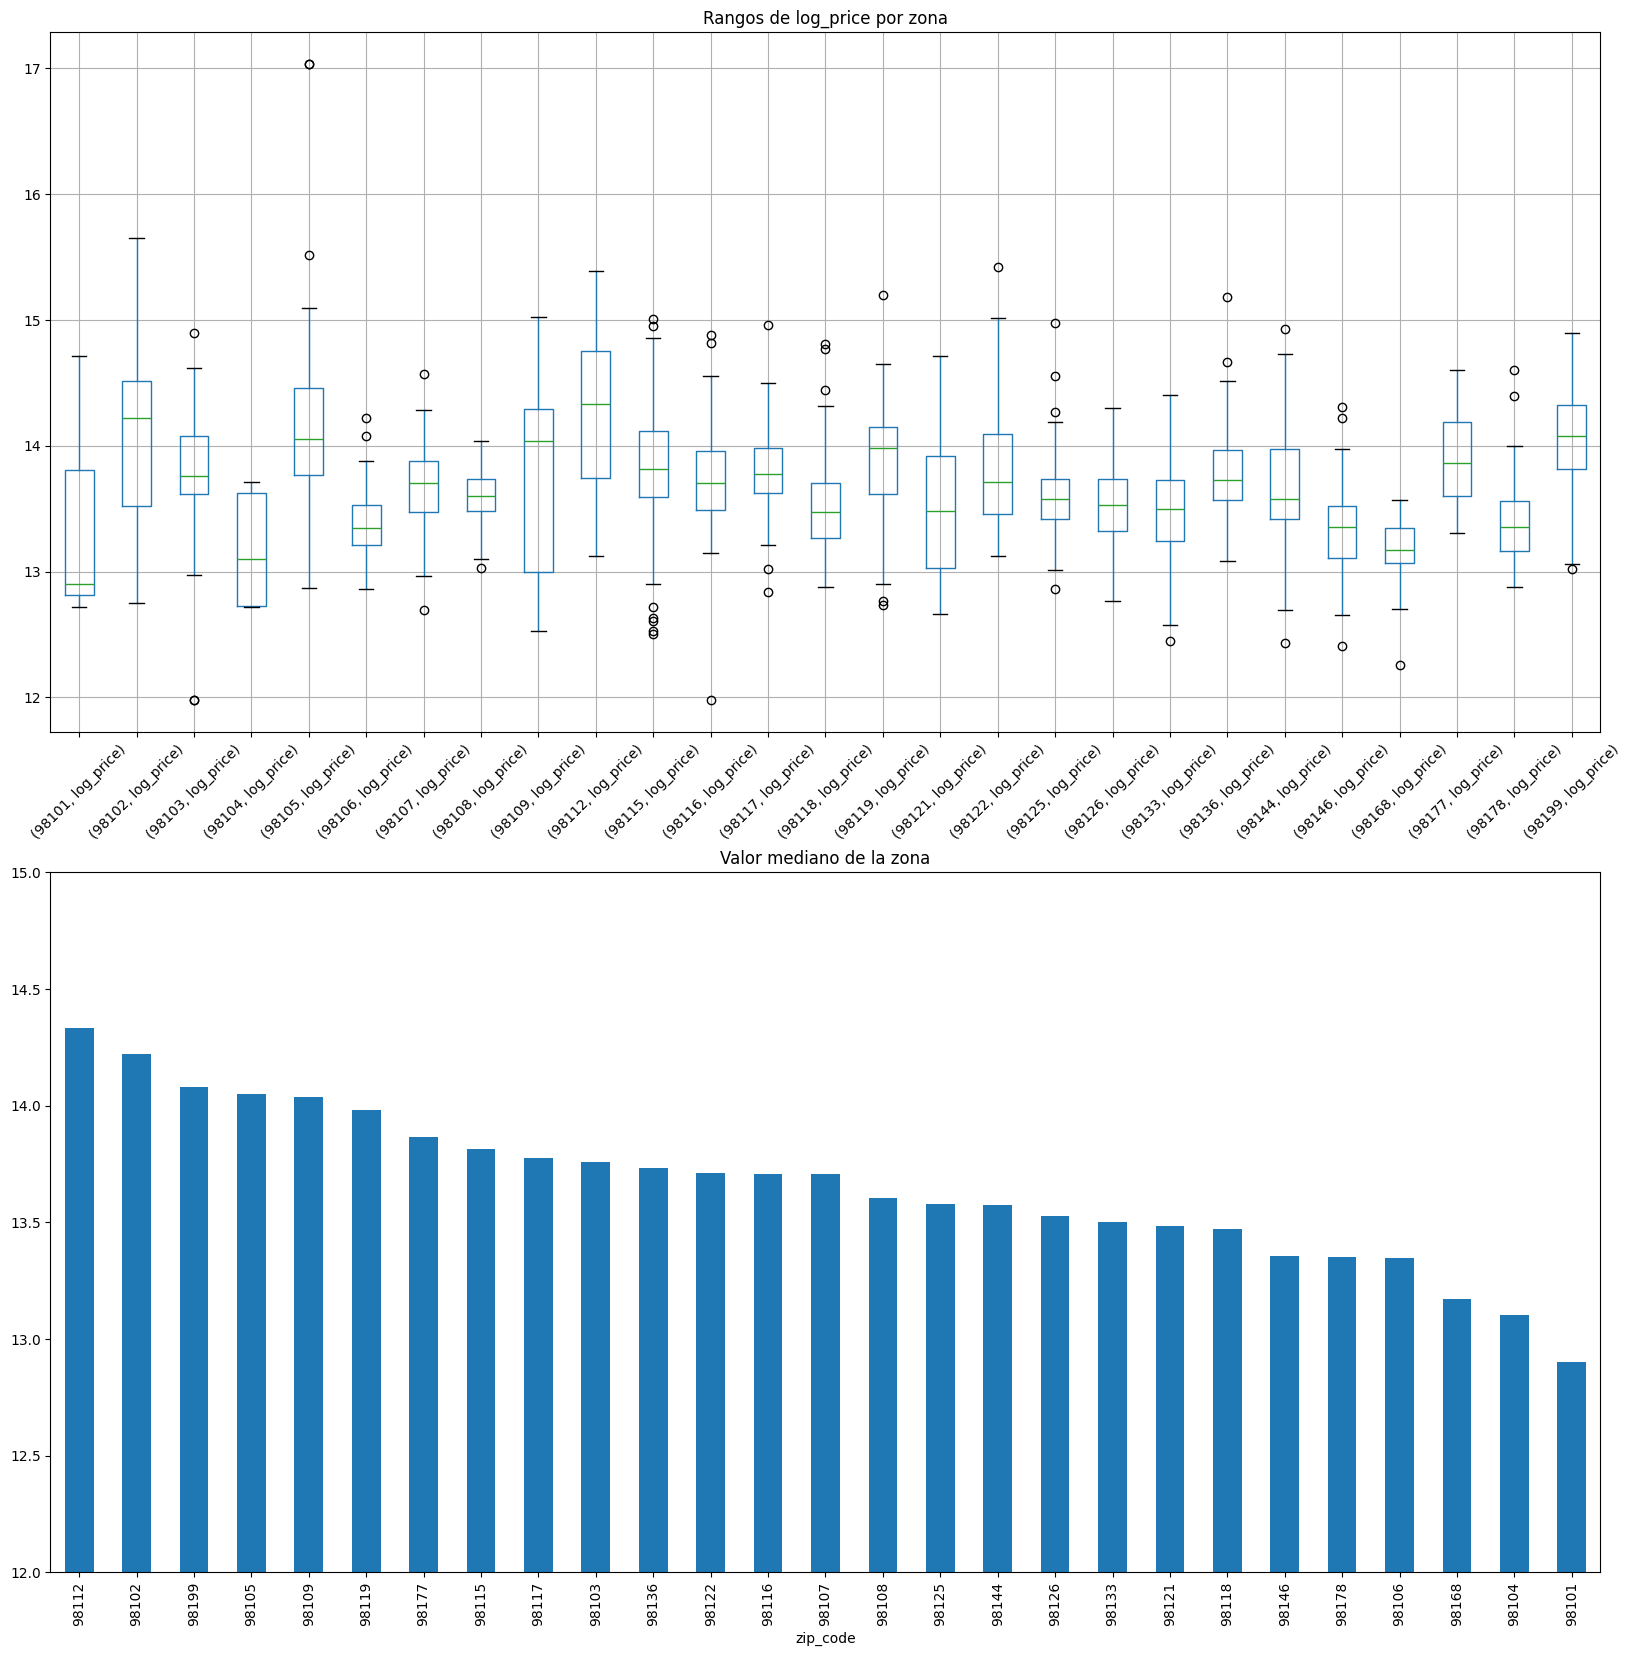

In [224]:
data = pd.DataFrame()
data["zip_code"] = X_train_prep["zip_code"]
data["log_price"] = y_train_prep
zone_group = data.groupby(by="zip_code")

# Gráficos
fig, axes = plt.subplots(2, 1, figsize=(20,20))
zone_group.boxplot(column="log_price", subplots=False, rot=45, ax=axes[0])
axes[0].set_title("Rangos de log_price por zona")

zone_group["log_price"].median().sort_values(ascending=False).plot.bar(ax=axes[1])
axes[1].set_ylim([12,15])
axes[1].set_title("Valor mediano de la zona")


Podemos ver que entre las zonas más caras podemos encontrar a Madison Park (98112) y Capitol Hill (98102) 

## Preprocesamiento para modelado de datos

Ahora vamos a preprocesar los datos para experimentar con modelos de Machine Learning. Nuestra tarea, predicción de precios, implica resolver un problema de regresión.
Contamos con la variable `zip_code` que es categórica nominal. Tendríamos que aplicarle una transformación One-Hot Encoding.

In [225]:
from sklearn.preprocessing import StandardScaler

# Seleccionamos las características categóricas
cat_features = X_train_prep.loc[:, ['zip_code']]

# Aplicamos una codificación One-Hot
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Aplicamos OHE y almacenamos el nombre de las nuevas columnas
cat_features_ohe = ohe.fit_transform(cat_features)
cat_col_names = ohe.get_feature_names_out(['zip_code'])


cat_features_ohe

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1408, 27))

In [226]:
cat_features_test = X_test_prep.loc[:, ['zip_code']]

cat_features_test_ohe = ohe.transform(cat_features_test)
cat_col_test_names = ohe.get_feature_names_out(['zip_code'])
cat_features_test_ohe

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], shape=(428, 27))

## Feature engeneering

A continuación, trataremos de extraer nuevas variables a partir de las existentes. El proceso consistirá en observar los predictores que están correlacionados, aplicar transformaciones sobre las variables existentes y tratar de combinarlas para crear otras nuevas.

In [227]:

# Seleccionamos las nuevas características numéricas
num_cols = ['beds', 'baths', 'size', 'lot_size']

# Escalamos las características numéricas
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_prep[num_cols])
# Escalamos las características numéricas del test set
X_test_num_scaled = scaler.transform(X_test_prep[num_cols])

# Convertimos a DataFrame y renombramos las columnas
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=[f'{col}_scaled' for col in num_cols], index=X_train_prep.index)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=[f'{col}_scaled' for col in num_cols], index=X_test_prep.index)

# Mostramos las primeras filas del DataFrame final
X_train_num_scaled.head()


,beds_scaled,baths_scaled,size_scaled,lot_size_scaled
0,-0.146688,0.257420,0.673564,-0.051210
1,0.656957,-0.228434,0.306803,-0.027270
2,0.656957,0.743273,0.097225,-0.058284
3,0.656957,0.743273,1.941511,-0.053842
5,-0.950333,-0.228434,-0.793481,0.068625


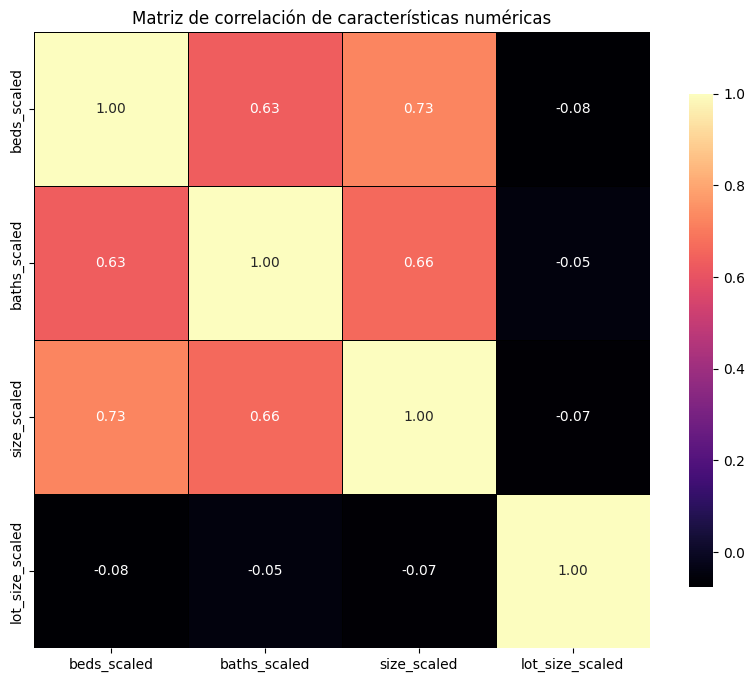

In [228]:

# Mostramos las primeras filas del DataFrame final
X_train_num_scaled.head()

# Creamos una matriz de corrlación para las variables numéricas
corr_matrix = X_train_num_scaled.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='magma', fmt='.2f', linewidths=0.5, linecolor='black', square=True, cbar_kws={"shrink": .8})
plt.title("Matriz de correlación de características numéricas") 
plt.show()



A primera vista podemos deducir que la característica `lot_size` no está correlacionada con el resto de predictores. Esto es lógico, porque el terreno que dispone fuera de la vivienda no influye en el número de baños o habitaciones que pueda haber dentro de ella.

Respecto al resto de predictores numéricos, podemos apreciar cierta correlación, especialmente entre las características `beds` y `size`. Podríamos aplicar un PCA para obtener nuevas características a partir de sus componentes.

In [229]:
# Aplicamos PCA a las características beds, baths y size
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# Seleccionamos las características numéricas que vamos a usar
pca_features = X_train_num_scaled[['size_scaled', 'beds_scaled', 'baths_scaled']]
# Aplicamos PCA
pca_result = pca.fit_transform(pca_features)
# Convertimos el resultado a un DataFrame
pca_df = pd.DataFrame(pca_result, columns=['pca1', 'pca2'], index=X_train_num_scaled.index)
# Mostramos las primeras filas del DataFrame PCA
pca_df.head()

,pca1,pca2
0,0.456104,0.095578
1,0.433958,-0.604429
2,0.856527,0.247305
3,1.942661,-0.269249
5,-1.147706,0.516168


Varianza explicada por el PCA: [0.7822773  0.12716818]


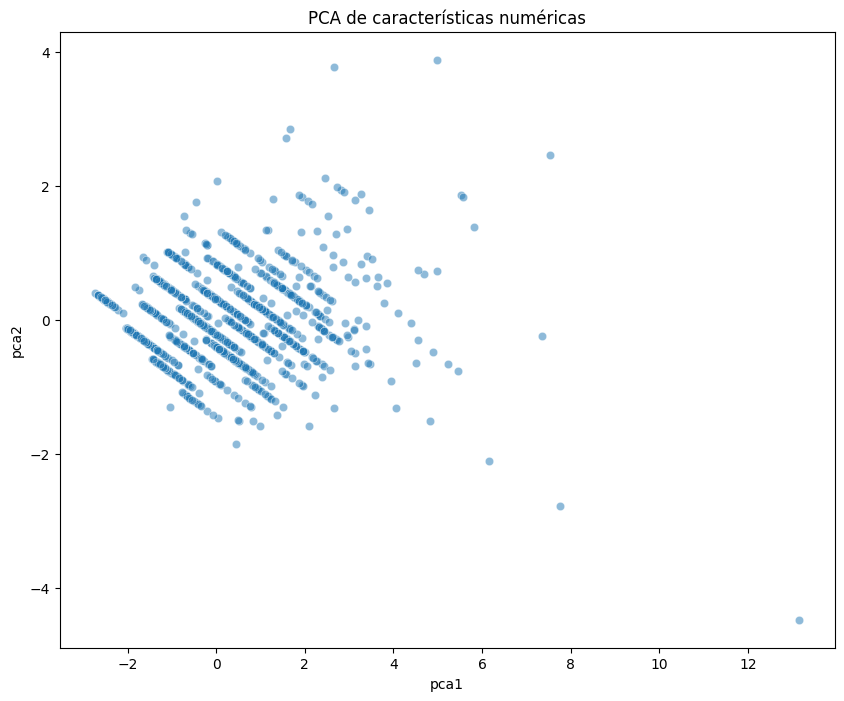

In [230]:
# Graficamos los resultados del PCA
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("PCA de características numéricas")
sns.scatterplot(data=pca_df, x='pca1', y='pca2', alpha=0.5)

# Cuanta información retiene el PCA
print(f"Varianza explicada por el PCA: {pca.explained_variance_ratio_}")


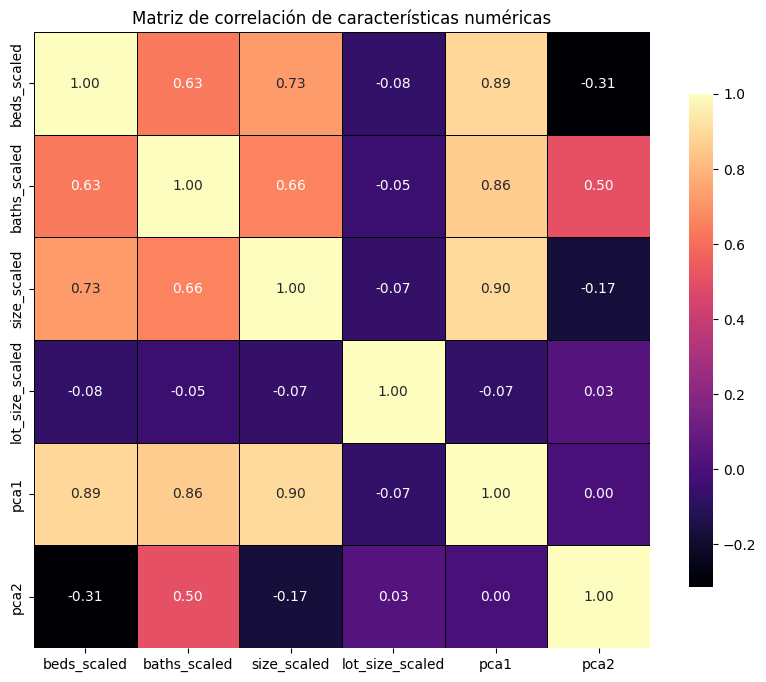

In [231]:
# Concatenamos las características numéricas escaladas con pca_df
X_train_num_scaled = pd.concat([X_train_num_scaled, pca_df], axis=1)

# Creamos una matriz de corrlación para las variables numéricas
corr_matrix = X_train_num_scaled.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='magma', fmt='.2f', linewidths=0.5, linecolor='black', square=True, cbar_kws={"shrink": .8})
plt.title("Matriz de correlación de características numéricas") 
plt.show()

A esta matriz de correlaciones le hemos agrecados las proyecciones de las dos primeras compononentes. Obsérvese que la correlación entre ella es 0 debido a que los vectores de carga son ortogonales. La primera componente mantiene una alta correlación con las variables usadas para su cálculo. La segunda componente almacenaba solamente un 12 % de la información, por lo que encontramos más ruido en los datos.

Ahora tenemos dos opciones. Usar como predictores numéricos:
1. Las variables escaladas de `baths`, `beds`, `size` y `lot_size`
2. Las dos primeras componentes principales + `lot_size_scaled`

In [232]:
# Concatenamos las características numéricas escaladas con variables categóricas codificadas
X_train_prep = pd.concat([X_train_num_scaled, pd.DataFrame(cat_features_ohe, columns=cat_col_names, index=X_train_prep.index)], axis=1)

X_train_op1 = X_train_prep[['beds_scaled', 'baths_scaled', 'size_scaled', 'lot_size_scaled']]
X_train_op2 = X_train_prep[['pca1', 'pca2', 'lot_size_scaled']]

X_train_opciones = [X_train_op1, X_train_op2]

for i, option in enumerate(X_train_opciones):
    X_train_opciones[i] = pd.concat([option, pd.DataFrame(cat_features_ohe, columns=cat_col_names, index=X_train_prep.index)], axis=1)

X_train_op1, X_train_op2 = X_train_opciones


In [ ]:
X_test_op1 = X_test_num_scaled[['beds_scaled', 'baths_scaled', 'size_scaled', 'lot_size_scaled']]
X_test_op1.head()

,beds_scaled,baths_scaled,size_scaled,lot_size_scaled
0,-0.146688,0.743273,0.946016,-0.056953
1,0.656957,2.686687,1.145115,-0.054394
2,-0.146688,-1.200141,-0.688692,-0.051057
3,-0.146688,-0.228434,0.432550,-0.031439
4,-0.146688,1.229126,-0.005468,-0.065239


In [ ]:
X_test_prep = pd.concat([X_test_op1, pd.DataFrame(cat_features_test_ohe, columns=cat_col_test_names, index=X_test_prep.index)], axis=1)
X_test_prep.head()

,beds_scaled,baths_scaled,size_scaled,lot_size_scaled,zip_code_98101,zip_code_98102,zip_code_98103,zip_code_98104,zip_code_98105,zip_code_98106,...,zip_code_98125,zip_code_98126,zip_code_98133,zip_code_98136,zip_code_98144,zip_code_98146,zip_code_98168,zip_code_98177,zip_code_98178,zip_code_98199
0,-0.146688,0.743273,0.946016,-0.056953,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.656957,2.686687,1.145115,-0.054394,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.146688,-1.200141,-0.688692,-0.051057,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.146688,-0.228434,0.432550,-0.031439,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.146688,1.229126,-0.005468,-0.065239,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**¿Cuáles serán los predictores más determinantes a la hora de predecir el precio de la casa?**

In [233]:
# Calculamos la correlación de los predictores numéricos con el precio
correlation = X_train_op1.corrwith(y_train_prep).sort_values(ascending=False)
# Mostramos la correlación
print("Correlación de los predictores numéricos con el precio:")
print(correlation)


Correlación de los predictores numéricos con el precio:
size_scaled        0.713915
baths_scaled       0.571481
beds_scaled        0.496427
zip_code_98105     0.194996
zip_code_98112     0.194423
zip_code_98199     0.128861
zip_code_98102     0.090784
zip_code_98115     0.074835
zip_code_98117     0.055763
zip_code_98177     0.053061
zip_code_98122     0.049897
zip_code_98119     0.041686
zip_code_98103     0.040653
zip_code_98136     0.033978
zip_code_98109     0.016381
zip_code_98116    -0.000892
zip_code_98144    -0.008824
zip_code_98107    -0.024220
zip_code_98101    -0.025035
zip_code_98108    -0.037111
zip_code_98121    -0.039195
zip_code_98125    -0.041607
zip_code_98104    -0.070721
zip_code_98126    -0.077468
zip_code_98118    -0.088204
zip_code_98133    -0.102061
lot_size_scaled   -0.108960
zip_code_98178    -0.112614
zip_code_98146    -0.124992
zip_code_98106    -0.154111
zip_code_98168    -0.192100
dtype: float64


Las características con más correlación con el precio son el tamaño de la vivienda, los baños y las camas (en ese orden). No obstante, los `zip_code` podrían jugar un papel fundamental dentro del rendimiento del modelo. 

# Modelado de datos

Vamos a hacer una evaluación rápida de los modelos que podemos utilizar para esta tarea de regresión.

In [234]:
# Con esta función evaluamos rápidamente varios modelos de regresión
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

def evaluacion_rapida_regresion(X, y, test_size=0.2, cv_folds=5):
    """Evaluación rápida de múltiples algoritmos de regresión"""
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.linear_model import LinearRegression, Ridge, Lasso
    from sklearn.svm import SVR
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    modelos = {
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(random_state=42),
        'Lasso': Lasso(random_state=42),
        'SVR': SVR()
    }
    
    resultados = {}
    
    for nombre, modelo in modelos.items():
        try:
            # Cross-validation
            cv_scores = cross_val_score(modelo, X_train, y_train, cv=cv_folds, scoring='r2')
            
            # Fit y predict
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)
            
            resultados[nombre] = {
                'CV_R2_Mean': cv_scores.mean(),
                'CV_R2_Std': cv_scores.std(),
                'Test_R2': r2_score(y_test, y_pred),
                'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
            }
            
        except Exception as e:
            resultados[nombre] = {'Error': str(e)}
    
    # Mostrar resultados
    print("📊 EVALUACIÓN RÁPIDA - REGRESIÓN")
    print("="*50)
    for nombre, metricas in resultados.items():
        if 'Error' in metricas:
            print(f"{nombre}: Error - {metricas['Error']}")
        else:
            print(f"{nombre}:")
            print(f"  CV R²: {metricas['CV_R2_Mean']:.4f} (±{metricas['CV_R2_Std']:.4f})")
            print(f"  Test R²: {metricas['Test_R2']:.4f}")
            print(f"  Test RMSE: {metricas['Test_RMSE']:.4f}")
            print()
    
    return modelos, resultados

In [235]:
# Evaluamos los modelos de regresión con los datos preprocesados: OPCIÓN 1
# (usando las variables escaladas de beds, baths, size y lot_size)
print("Evaluando modelos con la opción 1 (variables escaladas de beds, baths, size y lot_size)...")
modelos, resultados = evaluacion_rapida_regresion(X_train_op1, y_train_prep, test_size=0.2, cv_folds=5)
# Mostramos los resultados
for nombre, metricas in resultados.items():
    if 'Error' not in metricas:
        print(f"{nombre}: Test R² = {metricas['Test_R2']:.4f}, Test RMSE = {metricas['Test_RMSE']:.4f}")
    else:
        print(f"{nombre}: Error - {metricas['Error']}")

Evaluando modelos con la opción 1 (variables escaladas de beds, baths, size y lot_size)...
📊 EVALUACIÓN RÁPIDA - REGRESIÓN
Random Forest:
  CV R²: 0.6354 (±0.0524)
  Test R²: 0.5929
  Test RMSE: 0.3476

Gradient Boosting:
  CV R²: 0.6670 (±0.0405)
  Test R²: 0.6624
  Test RMSE: 0.3166

Linear Regression:
  CV R²: 0.6224 (±0.0512)
  Test R²: 0.5920
  Test RMSE: 0.3480

Ridge:
  CV R²: 0.6262 (±0.0492)
  Test R²: 0.5924
  Test RMSE: 0.3478

Lasso:
  CV R²: -0.0074 (±0.0067)
  Test R²: -0.0032
  Test RMSE: 0.5456

SVR:
  CV R²: 0.6651 (±0.0627)
  Test R²: 0.6301
  Test RMSE: 0.3313

Random Forest: Test R² = 0.5929, Test RMSE = 0.3476
Gradient Boosting: Test R² = 0.6624, Test RMSE = 0.3166
Linear Regression: Test R² = 0.5920, Test RMSE = 0.3480
Ridge: Test R² = 0.5924, Test RMSE = 0.3478
Lasso: Test R² = -0.0032, Test RMSE = 0.5456
SVR: Test R² = 0.6301, Test RMSE = 0.3313


In [236]:

# Evaluamos los modelos de regresión con los datos preprocesados: OPCIÓN 2
# (usando las dos primeras componentes principales + lot_size_scaled)
print("Evaluando modelos con la opción 2 (dos primeras componentes principales + lot_size_scaled)...")
modelos, resultados = evaluacion_rapida_regresion(X_train_op2, y_train_prep, test_size=0.2, cv_folds=5)
# Mostramos los resultados
for nombre, metricas in resultados.items():
    if 'Error' not in metricas:
        print(f"{nombre}: Test R² = {metricas['Test_R2']:.4f}, Test RMSE = {metricas['Test_RMSE']:.4f}")
    else:
        print(f"{nombre}: Error - {metricas['Error']}")

Evaluando modelos con la opción 2 (dos primeras componentes principales + lot_size_scaled)...
📊 EVALUACIÓN RÁPIDA - REGRESIÓN
Random Forest:
  CV R²: 0.5776 (±0.0631)
  Test R²: 0.5298
  Test RMSE: 0.3736

Gradient Boosting:
  CV R²: 0.6027 (±0.0565)
  Test R²: 0.6008
  Test RMSE: 0.3442

Linear Regression:
  CV R²: 0.5704 (±0.0505)
  Test R²: 0.5418
  Test RMSE: 0.3688

Ridge:
  CV R²: 0.5750 (±0.0491)
  Test R²: 0.5420
  Test RMSE: 0.3687

Lasso:
  CV R²: -0.0074 (±0.0067)
  Test R²: -0.0032
  Test RMSE: 0.5456

SVR:
  CV R²: 0.5971 (±0.0647)
  Test R²: 0.5649
  Test RMSE: 0.3594

Random Forest: Test R² = 0.5298, Test RMSE = 0.3736
Gradient Boosting: Test R² = 0.6008, Test RMSE = 0.3442
Linear Regression: Test R² = 0.5418, Test RMSE = 0.3688
Ridge: Test R² = 0.5420, Test RMSE = 0.3687
Lasso: Test R² = -0.0032, Test RMSE = 0.5456
SVR: Test R² = 0.5649, Test RMSE = 0.3594


El uso de las dos primeras componentes de PCA empeora el resultado respecto al uso de las variables originales escaladas.

Parece que el modelo que mejor resultados ha dado ha sido Gradient Boosting. Podríamos tratar de mejorar los resultados tratando de hallar los hiperparámetros óptimos de este modelo (que a priori es el más adecuado para este caso).

Veamos cuales son las variables más importantes del modelo Gradient Boosting.

In [239]:
# Creamos un estimador Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=42)

# Entrenamos el modelo con la opción 1
gb_model.fit(X_train_op1, y_train_prep)

mdi_importances = pd.Series(gb_model.feature_importances_, index=gb_model.feature_names_in_)
mdi_importances.sort_values(ascending = False, inplace=True)

# Mostramos las características más importantes
print("Características más importantes del modelo Gradient Boosting:")
print(mdi_importances)

Características más importantes del modelo Gradient Boosting:
size_scaled        0.677107
baths_scaled       0.078762
lot_size_scaled    0.046816
zip_code_98168     0.040197
zip_code_98105     0.026754
beds_scaled        0.026019
zip_code_98112     0.014291
zip_code_98106     0.012547
zip_code_98146     0.012505
zip_code_98178     0.011800
zip_code_98118     0.011288
zip_code_98199     0.008510
zip_code_98102     0.007569
zip_code_98126     0.005340
zip_code_98133     0.005249
zip_code_98109     0.004564
zip_code_98108     0.003407
zip_code_98103     0.002053
zip_code_98117     0.001852
zip_code_98101     0.001294
zip_code_98125     0.000805
zip_code_98121     0.000555
zip_code_98136     0.000487
zip_code_98144     0.000173
zip_code_98116     0.000055
zip_code_98104     0.000000
zip_code_98107     0.000000
zip_code_98115     0.000000
zip_code_98119     0.000000
zip_code_98122     0.000000
zip_code_98177     0.000000
dtype: float64


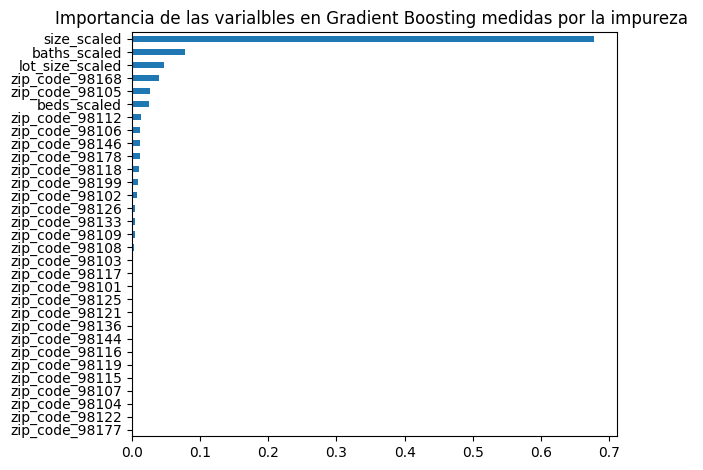

In [240]:
ax = mdi_importances.sort_values(ascending=True).plot.barh()
ax.set_title("Importancia de las varialbles en Gradient Boosting medidas por la impureza ")
ax.figure.tight_layout()

Ahora haremos una búsqueda recursiva de la mejor combinación de variables.

In [241]:
min_size = 2
max_size = 30
sizes = range(min_size-1,max_size)

In [242]:
X_train_var_select, X_val, y_train_var_select, y_val = train_test_split(X_train_op1, y_train_prep, test_size=0.2, random_state=42)


In [257]:
from sklearn.metrics import r2_score

#Inicializamos la mejor accuracy a la accuracy del caso base
best_r2 = 0.66
best_model = gb_model

min_size = 2
max_size = 31
sizes = range(min_size-1,max_size)

# Creamos un bucle para recorrer el rango "sizes" en orden inverso.
for size in reversed(sizes): 

    # creamos dos nuevos conjuntos X_train_rfe e X_test_rfe que sólo contengan las columnas correspondientes
    # variables que hay que comprobar
    
    X_train_gb = X_train_var_select[X_train_var_select.columns[X_train_var_select.columns.isin(mdi_importances.index[0:size+1])]]
    X_test_gb = X_val[X_val.columns[X_val.columns.isin(mdi_importances.index[0:size+1])]]
   
    # Entrenamos un regresor gradient boosting y calculamos su precisión utilizando los conjuntos 
    # X_train_rfe y X_test_rfe (utiliza random_state=np.random.seed(1234)

    
    gb_model = GradientBoostingRegressor(random_state=42) 
    gb_model.fit(X_train_gb, y_train_var_select)
    y_pred = gb_model.predict(X_test_gb)
    r2 = r2_score(y_val, y_pred)
  
    # Si el accuracy obtenido es mayor o igual al best_accuracy hasta el momento
    # actualizar best_accuracy y best_model.    

    if r2 >= best_r2:
        best_r2 = r2
        best_model = gb_model
   
    # imprime el tamaño del conjunto de variables y su r2
    print(size+1, r2)

print("Mejor número de variables: ", best_model.n_features_in_, "Exactitud obtenida: ", best_r2)

31 0.6623590450001633
30 0.6623397341510013
29 0.6612930140692983
28 0.6623410094095716
27 0.6620830103466979
26 0.6622638001329403
25 0.6548355043991574
24 0.65509051884362
23 0.6551444583426651
22 0.665506664133148
21 0.6630359606827572
20 0.6597985874226321
19 0.662356402436603
18 0.663900302608532
17 0.6625308971760988
16 0.6517796726345024
15 0.6403047713539871
14 0.6431411566568348
13 0.6534424393110208
12 0.6431772450515009
11 0.6404626629724557
10 0.6332579297524454
9 0.6327561179581666
8 0.6213540973535137
7 0.6248365683065619
6 0.5984041564882043
5 0.5788012109910714
4 0.5291820379934848
3 0.4948793188309817
2 0.4442940102796372
Mejor número de variables:  22 Exactitud obtenida:  0.665506664133148


In [258]:
# Nos quedamos con las variables del mejor modelo
best_feature_set = best_model.feature_names_in_
X_train_op1 = X_train_op1[best_feature_set]

In [262]:
print(X_train_op1.shape)
print(best_feature_set.shape)

(1408, 22)
(22,)


El mejor modelo se obtendría usando las 22 mejores variables. Nos queda hacer una búsqueda de hiperparámetros.

Text(0.5, 1.0, 'R2 en validación cruzada vs hiperparámetro ccp_alpha')

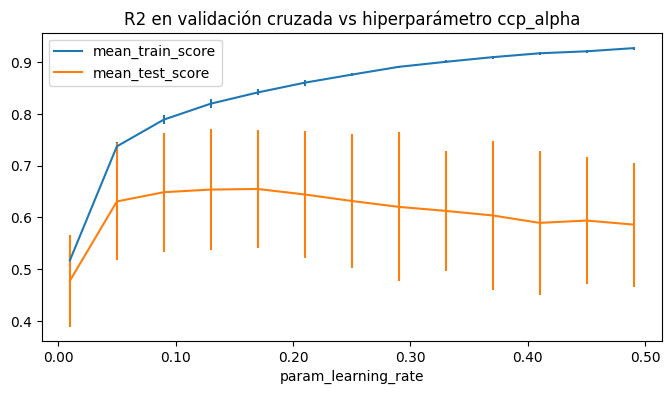

In [ ]:
from matplotlib.ticker import FormatStrFormatter
from sklearn.model_selection import GridSearchCV

# Definimos el grid de hiperparámetros a buscar para Gradient Boosting Regressor
# np.arange(0.0)
param_grid = {
              'learning_rate': np.arange(0.01, 0.51, 0.04),

}
              
grid = GridSearchCV(
        # Configuramos el árbol para que se cree a máxima profundidad para buscar el mejor valor de poda
        estimator = GradientBoostingRegressor(
                            max_depth         = 3,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 42
                       ),
        param_grid = param_grid,
        cv         = 10,
        refit      = True,
        return_train_score = True
      )
# Entrenamos el grid para buscar el mejor valor.
grid.fit(X_train_op1, y_train_prep)
# Mostramos gráficamente todos los valores obtenidos para analizar el mejor valor de poda
fig, ax = plt.subplots(figsize=(8, 4))
scores = pd.DataFrame(grid.cv_results_)

scores.plot(x='param_learning_rate', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_learning_rate', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title("R2 en validación cruzada vs hiperparámetro learning_rate")


El mejor valor para el learning_rate se podría encontrar entorno a 0.15.

Text(0.5, 1.0, 'R2 en validación cruzada vs hiperparámetro n_estimators')

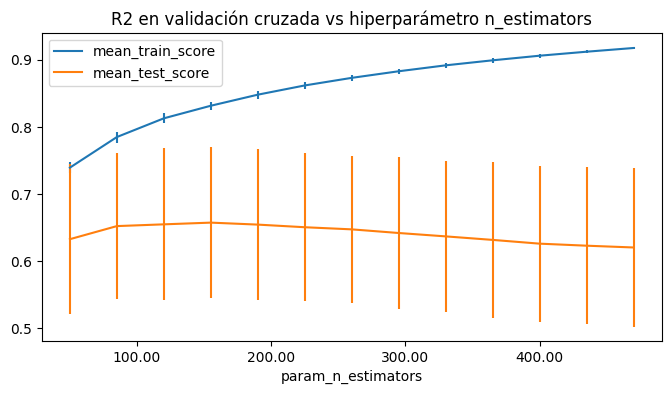

In [ ]:
from matplotlib.ticker import FormatStrFormatter
from sklearn.model_selection import GridSearchCV

# Definimos el grid de hiperparámetros a buscar para Gradient Boosting Regressor

param_grid = {

              'n_estimators': np.arange(50, 501, 35),
}
              
grid = GridSearchCV(
        # Configuramos el árbol para que se cree a máxima profundidad para buscar el mejor valor de poda
        estimator = GradientBoostingRegressor(
                            max_depth         = 3,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 42
                       ),
        param_grid = param_grid,
        cv         = 10,
        refit      = True,
        return_train_score = True
      )
# Entrenamos el grid para buscar el mejor valor.
grid.fit(X_train_op1, y_train_prep)
# Mostramos gráficamente todos los valores obtenidos para analizar el mejor valor de poda
fig, ax = plt.subplots(figsize=(8, 4))
scores = pd.DataFrame(grid.cv_results_)

scores.plot(x='param_n_estimators', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_n_estimators', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title("R2 en validación cruzada vs hiperparámetro n_estimators")


El mejor valor para el número de estimadores se podría encontrar entorno a 100.

Text(0.5, 1.0, 'R2 en validación cruzada vs hiperparámetro n_estimators')

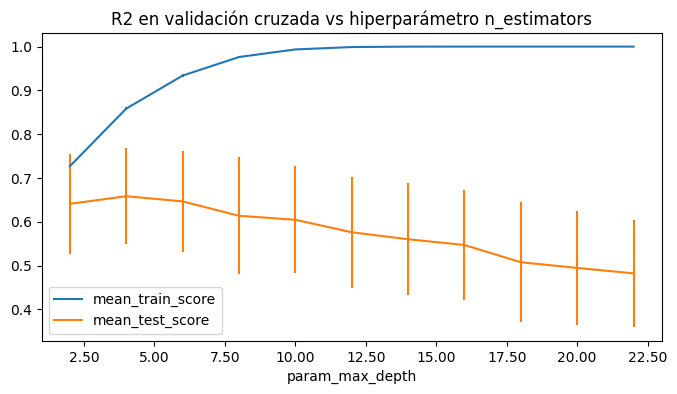

In [ ]:
from matplotlib.ticker import FormatStrFormatter
from sklearn.model_selection import GridSearchCV

# Definimos el grid de hiperparámetros a buscar para Gradient Boosting Regressor

param_grid = {

              'max_depth': np.arange(2, 23, 2),
}
              
grid = GridSearchCV(
        # Configuramos el árbol para que se cree a máxima profundidad para buscar el mejor valor de poda
        estimator = GradientBoostingRegressor(
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 42
                       ),
        param_grid = param_grid,
        cv         = 10,
        refit      = True,
        return_train_score = True
      )
# Entrenamos el grid para buscar el mejor valor.
grid.fit(X_train_op1, y_train_prep)
# Mostramos gráficamente todos los valores obtenidos para analizar el mejor valor de poda
fig, ax = plt.subplots(figsize=(8, 4))
scores = pd.DataFrame(grid.cv_results_)

scores.plot(x='param_max_depth', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_max_depth', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title("R2 en validación cruzada vs hiperparámetro max_depth")


In [50]:
from matplotlib.ticker import FormatStrFormatter
from sklearn.model_selection import GridSearchCV

# Definimos el grid de hiperparámetros a buscar para Gradient Boosting Regressor

param_grid = {
              'learning_rate': np.arange(0.01, 0.51, 0.04),
              'n_estimators':  np.arange(50, 501, 35),
}
              
grid = GridSearchCV(
        estimator = GradientBoostingRegressor(
                            max_depth         = 4,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 42
                       ),
        param_grid = param_grid,
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

# Entrenamos el grid para buscar el mejor valor.
grid.fit(X_train_op1, y_train_prep)


GridSearchCV(cv=10,
             estimator=GradientBoostingRegressor(max_depth=4, random_state=42),
             param_grid={'learning_rate': array([0.01, 0.05, 0.09, 0.13, 0.17, 0.21, 0.25, 0.29, 0.33, 0.37, 0.41,
       0.45, 0.49]),
                         'n_estimators': array([ 50,  85, 120, 155, 190, 225, 260, 295, 330, 365, 400, 435, 470])},
             return_train_score=True)

In [51]:
grid.best_score_


np.float64(0.6574731016482359)

In [53]:
scores = pd.DataFrame(grid.cv_results_)
scores.to_csv("../results/grid_search_results.csv", index=False)

# Evaluación del modelo

Vamos a entrenar con todos los datos de entrenamiento (incluyendo los de validación) el mejor modelo encontrado tras la búsqueda de hiperparámetros. Después lo evaluaremos con los datos de test que apartamos al inicio del proyecto.

In [263]:
X_test_prep.head()

,beds_scaled,baths_scaled,size_scaled,lot_size_scaled,zip_code_98101,zip_code_98102,zip_code_98103,zip_code_98105,zip_code_98106,zip_code_98108,...,zip_code_98117,zip_code_98118,zip_code_98121,zip_code_98125,zip_code_98126,zip_code_98133,zip_code_98146,zip_code_98168,zip_code_98178,zip_code_98199
0,-0.146688,0.743273,0.946016,-0.056953,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.656957,2.686687,1.145115,-0.054394,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.146688,-1.200141,-0.688692,-0.051057,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.146688,-0.228434,0.432550,-0.031439,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.146688,1.229126,-0.005468,-0.065239,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [264]:
# Entrenamos el modelo con los mejores hiperparámetros
best_model = GradientBoostingRegressor(
    max_depth=4,
    n_estimators=120,
    learning_rate=0.09,
    random_state=42,

)

best_model.fit(X_train_op1, y_train_prep)

# Selecciona las mismas columnas en el test set que en el entrenamiento
X_test_prep = X_test_prep[best_feature_set]

# Evaluamos el modelo en el conjunto de test
test_score = best_model.score(X_test_prep, y_test_prep)
print("R² en el conjunto de test:", test_score)

R² en el conjunto de test: 0.6597500016139771


# Conclusiones

El modelo Gradient Boosting obtenido es capaz de explicar el 66 % de la variabilidad total del precio de la vivienda. Por lo tanto, el 34 % restante dependerá de errores aleatorios y otros factores restantes que no hemos tenido en cuenta para la elaboración del modelo.

Puede ser que otros modelos se consiga una mayor explicabilidad de los datos. A partir de este notebook podríamos explorar nuevas que nos aporte un mayor rendimiento en las predicciones. Sería clave mejorar el filtrado de los datos de entrenamiento, para aumentar la calidad de estos.